In [110]:
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np
from zlib import crc32
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

housing = pd.read_csv("housing.csv")

In [96]:
# this creates a testset for us from the dataset we use 20% here
def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    
    return data.iloc[train_indices], data.iloc[test_indices]

In [97]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)

In [98]:
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    
    return data.loc[~in_test_set], data.loc[in_test_set]

In [99]:
# to make sure that the test set is the same every time we run the program we can check the row index as id
housing_with_id = housing.reset_index() # adds an index column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

In [100]:
# latatude and longiude are stable for each district so we can use them as id
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

In [101]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [102]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

Text(0, 0.5, 'Number of Districts')

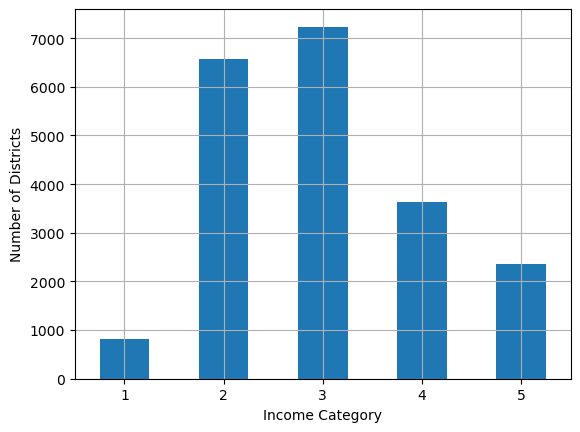

In [103]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income Category")
plt.ylabel("Number of Districts")

In [104]:
# this generates 10 different stratified splits of the dataset into training and test sets
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append((strat_train_set_n, strat_test_set_n))

strat_train_set, strat_test_set = strat_splits[0]
# this is a shorter way to get a single stratified split
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42
)

In [105]:
# we can now remove the income_cat attribute so the data is back to its original state
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [106]:
# we want to make a copy so we can revert back to in case we mess up the training set
housing = strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

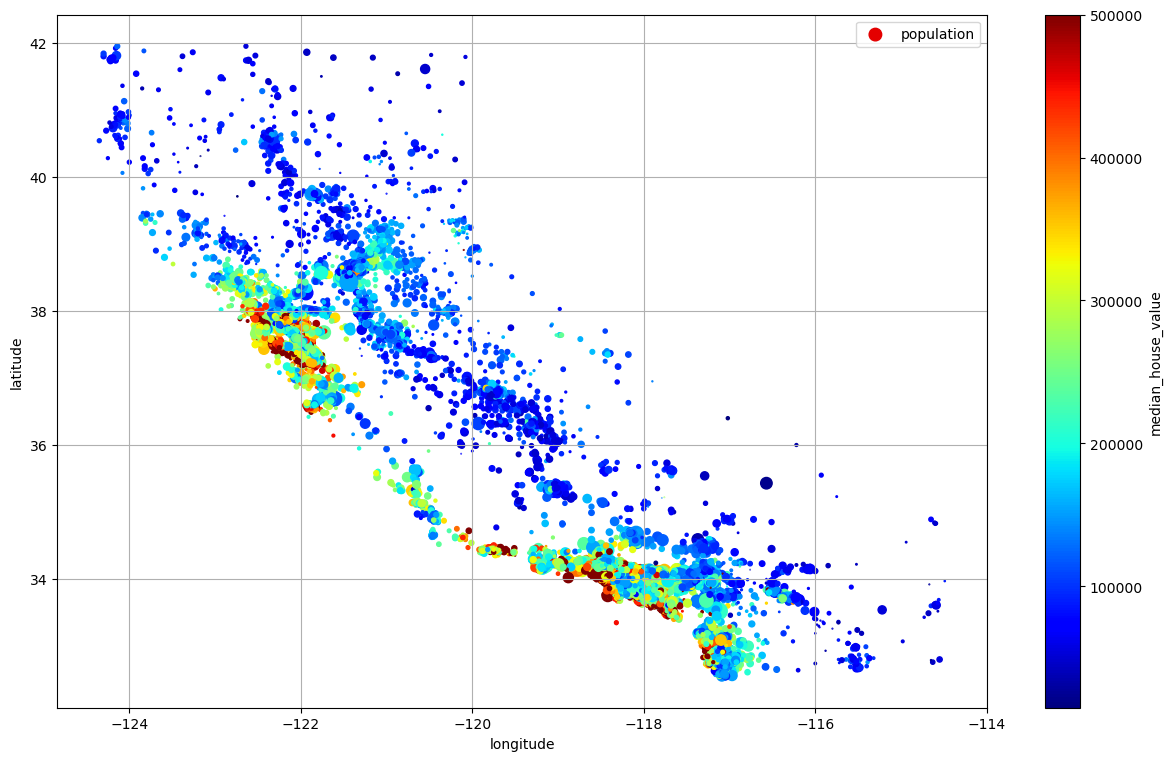

In [107]:
# this is a scatter plot of the latatude and longitude of the districts
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, s=housing["population"] / 100, label="population", c="median_house_value", cmap="jet", colorbar=True, legend=True, sharex = False, figsize=(15, 9))

In [109]:
# this gives us pearson's r which is the standard correlation coefficient
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

/var/folders/8q/0wn9p2n54hb1x_gb6ckxsdxr0000gn/T/ipykernel_2256/3745312948.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

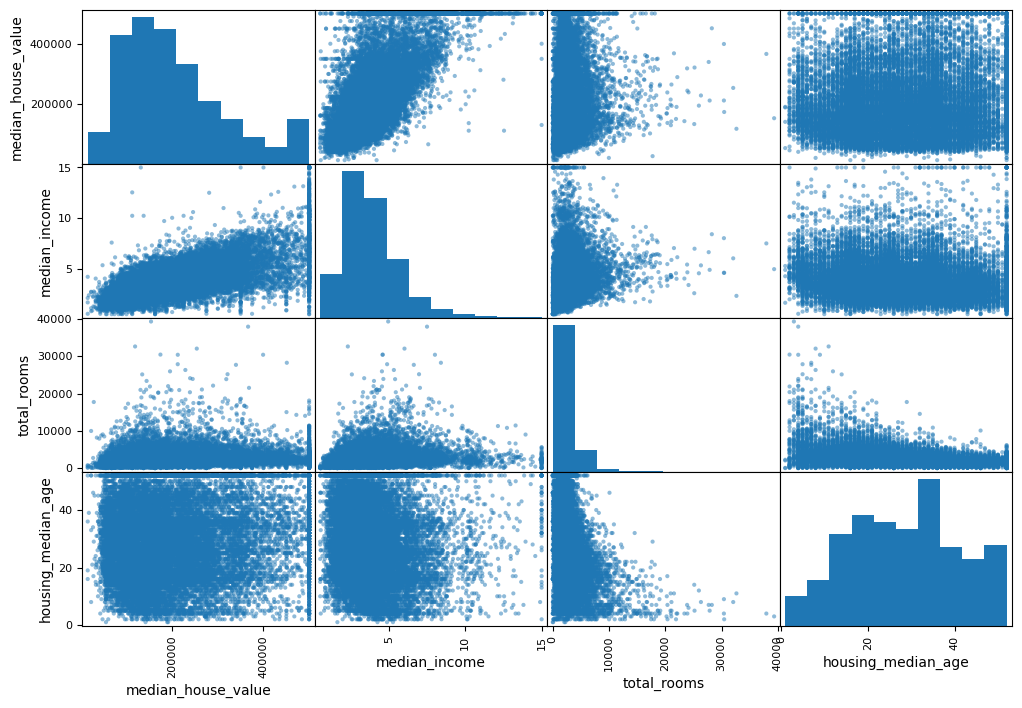

In [112]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

<Axes: xlabel='median_income', ylabel='median_house_value'>

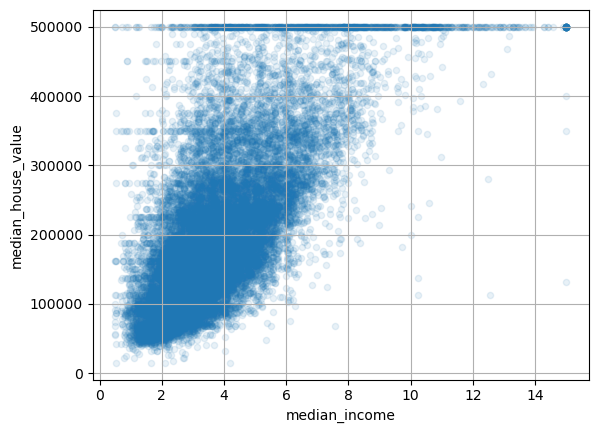

In [113]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, grid=True)

In [114]:
# this will create more useful attributes for us
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [115]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

/var/folders/8q/0wn9p2n54hb1x_gb6ckxsdxr0000gn/T/ipykernel_2256/826279322.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value     1.000000
median_income          0.688075
rooms_per_household    0.151948
total_rooms            0.134153
housing_median_age     0.105623
households             0.065843
total_bedrooms         0.049686
people_per_house      -0.023737
population            -0.024650
longitude             -0.045967
latitude              -0.144160
bedrooms_ratio        -0.255880
Name: median_house_value, dtype: float64